# Programming Assignment 2: Naïve Bayes
## Part 2: Classification

#### Name: Abdul Rafay
#### Roll Number: 24100173

### Instructions
*   In this part of the assignment you will be implementing a Naïve Bayes Classification Model for classification from scratch.
*   Your code must be in the Python programming language.
*   You are encouraged to use procedural programming and throughly comment your code.
*   For Part 2, you can only use standard libraries i.e. numpy, pandas, regex, matplotlib and scipy. You are **not** allowed to use any machine learning toolkits or libraries for training and testing your model. 
*   **Carefully read the submission guidelines, plagiarism and late days policy.**

### Submission Guidelines
Submit your code both as notebook file (.ipynb) and python script (.py) as individual files on LMS. Name both files as RollNumber_PA2_PartNum, i.e. this part should be named as `2xxxxxxx_PA4_2`. If you don’t know how to save .ipynb as .py see [this](https://i.stack.imgur.com/L1rQH.png). Failing to submit any one of them might result in the reduction of marks. All cells **MUST** be run to get credit.

### Plagiarism Policy
The code **MUST** be done independently. Any plagiarism or cheating of work from others or the internet will be immediately referred to the DC. If you are confused about what constitutes plagiarism, it is **YOUR** responsibility to consult with the instructor or the TA in a timely manner. No “after the fact” negotiations will be possible. The only way to guarantee that you do not lose marks is **DO NOT LOOK AT ANYONE ELSE'S CODE NOR DISCUSS IT WITH THEM**.

### Late Days Policy

The deadline for the assignment is final. However, in order to accommodate all the 11th-hour issues, there is a late submission policy i.e. you can submit your assignment within 3 days after the deadline with a 25% deduction each day.


### Introduction

In this part, you will be implementing and training a Naïve Bayes Classification model to classify news articles into different categories. Specifically, you will need to implement [this](https://drive.google.com/file/d/1lNXwNpU6ydeP8I6cPsXLdbA4RQu17G9E/view?usp=sharing) algorithm. For more details of the algorithm and insights into the Naïve Bayes, you can also consult [Chapter 4](https://web.stanford.edu/~jurafsky/slp3/4.pdf) of the Speech and Language Processing book as reference.


### Dataset
You will be using the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset) for the purposes of this part of the assignment. This contains 120,000 training samples and 7600 testing samples of news articles belonging to 4 categories: World, Sports, Business, and Sci/Tech. 
The data has already been spilt into train and test files.
You're required to implement a model that classifies the articles among the 4 aforementioned categories.

Start by importing all required libraries here.

In [47]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba as nb
import seaborn as sns

### 2.1 - Loading and Preprocessing the Dataset

Load the dataset - both training and test samples

In [2]:
# code here

dataset_path = 'DataP2'

train = pd.read_csv(dataset_path + '/train.csv')
test  = pd.read_csv(dataset_path + '/test.csv')

# remove the Title column from the train and test data
train.drop('Title', axis=1, inplace=True)
test.drop('Title', axis=1, inplace=True)

test.head()

,Class Index,Description
0,3,Unions representing workers at Turner Newall...
1,4,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,AP - A company founded by a chemistry research...
3,4,AP - It's barely dawn when Mike Fitzpatrick st...
4,4,AP - Southern California's smog-fighting agenc...


In [3]:
X_train = train['Description'].to_numpy()
y_train = train['Class Index'].to_numpy()

X_test = test['Description'].to_numpy()
y_test = test['Class Index'].to_numpy()

# create a copy of the original data
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

In [4]:
stop_words = []

with open(dataset_path + '/stop_words.txt', 'r') as f:
    for line in f:
        stop_words.append(line.strip())

Use regex to pre-process the data loaded. Go through the data and use your own discretion to decide on what kind of pre-processing might be required.

In [5]:
# code here
# remove stop words from the train and test data
def remove_stop_words(X):
    for i in range(len(X)):
        X[i] = ' '.join([word for word in X[i].split() if word not in stop_words])
    return X

# remove punctuation from the train and test data
def remove_punctuation(X):
    for i in range(len(X)):
        X[i] = re.sub(r'[^\w\s]','',X[i])
    return X

# remove digits from the train and test data
def remove_digits(X):
    for i in range(len(X)):
        X[i] = re.sub(r'\d+','',X[i])
    return X

# remove extra spaces from the train and test data
def remove_extra_spaces(X):
    for i in range(len(X)):
        X[i] = re.sub(r'\s+',' ',X[i])
    return X

# convert all characters to lower case from the train and test data
def lower_case(X):
    for i in range(len(X)):
        X[i] = X[i].lower()
    return X

# remove urls from the train and test data
def remove_urls(X):
    for i in range(len(X)):
        X[i] = re.sub(r'http\S+','',X[i])
    return X

X_train = lower_case(X_train)
X_train = remove_stop_words(X_train)
X_train = remove_punctuation(X_train)
X_train = remove_digits(X_train)
X_train = remove_urls(X_train)
X_train = remove_extra_spaces(X_train)

X_test = lower_case(X_test)
X_test = remove_stop_words(X_test)
X_test = remove_punctuation(X_test)
X_test = remove_digits(X_test)
X_test = remove_urls(X_test)
X_test = remove_extra_spaces(X_test)

Show the results of your preprocessing by printing a random sample of 10 articles before and after pre-processing.

In [6]:
np.random.seed(0)
print("Before preprocessing: ")
print(np.random.choice(X_train_orig, 10))

np.random.seed(0)
print("After preprocessing: ")
print(np.random.choice(X_train, 10))

Before preprocessing: 
['Japanese electronics giant NEC Corp has begun selling the world #39;s fastest supercomputer. NEC claimed its SX-8 is the most powerful  quot;vector-type quot; supercomputer, with a sustainable '
 'PalmSource finally unveiled its new OS, version 1.1 of Palm OS Cobalt, as  quot;the first PalmOS designed specifically to support phones quot;.'
 'Pakistani security forces have arrested more suspected militants in a series of raids following Sunday #39;s killing of a top al-Qaida leader and the arrest of two of his aides.'
 ' NEW YORK (Reuters) - FedEx Corp. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=FDX.N target=/stocks/quickinfo/fullquote"&gt;FDX.N&lt;/A&gt;, the world\'s top  air-express shipper, on Thursday said quarterly profit more  than tripled on strength in its international, ground and  freight businesses, and the company raised its full-year  earnings forecast.'
 'com September 30, 2004, 9:28 AM PT. There #39;s no doubt the Internet 

### 2.2 - Training Naïve Bayes

Create a bag of words representation for the data. Also report the number of unique words in your vocabulary, as well as in each class.

In [7]:
# create vocabulary from training set
vocab = set()
for i in range(len(X_train)):
    vocab.update(X_train[i].split())

print("Vocabulary size: ", len(vocab))
vocab = list(vocab)

Vocabulary size:  84045


In [9]:
# split the data based on the class
def split_data(X, y):
    X_split = {}
    for i in range(len(X)):
        if y[i] not in X_split.keys():
            X_split[y[i]] = []
        X_split[y[i]].append(X[i])
    return X_split

# function to create vocab for each class
def create_vocab(X, y):
    vocab = {}
    for i in range(len(X)):
        if y[i] not in vocab.keys():
            vocab[y[i]] = set()
        vocab[y[i]].update(X[i].split())

    # convert the vocab to a list
    for key in vocab.keys():
        vocab[key] = list(vocab[key])
    return vocab

# function to create a dictionary of words and their counts for each class
def create_word_counts(X, y):
    word_counts = {}
    for i in range(len(X)):
        if y[i] not in word_counts.keys():
            word_counts[y[i]] = {}
        for word in X[i].split():
            if word not in word_counts[y[i]].keys():
                word_counts[y[i]][word] = 0
            word_counts[y[i]][word] += 1
    return word_counts

In [13]:
X_train_split = split_data(X_train, y_train)

# create vocab for each class
vocab_class = create_vocab(X_train, y_train)


# create word counts for each class
word_counts_class = create_word_counts(X_train, y_train)

# print the size of each class vocab
for key in vocab_class:
    print("Class: ", key, "Vocab size: ", len(vocab_class[key]), "Class size: ", len(X_train_split[key]), "Word count: ", sum(word_counts_class[key].values()))

Class:  3 Vocab size:  32297 Class size:  30000 Word count:  603274
Class:  4 Vocab size:  39887 Class size:  30000 Word count:  580779
Class:  2 Vocab size:  32382 Class size:  30000 Word count:  580901
Class:  1 Vocab size:  33837 Class size:  30000 Word count:  604775


In [21]:
# function to create bag of words representation for each class.
# @nb.njit(fastmath=True)
def create_bow(sentence, vocab, len_train_vocab):
    bow = np.ones(len_train_vocab).astype('uint8')
    sentences = sentence.split()
    for word in sentences:
        # if word in vocab:
        bow[vocab.index(word)] += 1
    return bow
    
train_bow_list = []
x = len(vocab)
for class_index, class_data in X_train_split.items():
    print("\nClass: ", class_index)
    j = 1000
    for sentence in class_data:
        bow = create_bow(sentence, vocab, x)
        train_bow_list.append(bow)
        # print a dynamic progress bar
        if j > 1000:
            print('\r', end='')
            print('Progress: [{0:50s}] {1:.1f}%'.format('#' * int((j / len(class_data)) * 50), (j / len(class_data)) * 100), end='')
            # write to file
        j += 1


Class  1
Progress: [################################################# ] 99.9%
Class  2
Progress: [################################################# ] 99.9%
Class  3
Progress: [################################################# ] 99.9%
Class  4
Progress: [################################################# ] 99.9%
BOW representation finished.


Implement a general `trainNaiveBayes` function that returns log priors and liklehoods for each class in a given dataset. Apply Laplace smoothing.

In [20]:
# create a dataframe of sentences and their classes
df = pd.DataFrame({'sentence': X_train, 'class': y_train})

classes = df['class'].unique()

In [23]:
word_counts = {}

for sentence in df['sentence']:
    for word in sentence.split():
        if word not in word_counts.keys():
            word_counts[word] = 1
        word_counts[word] += 1

In [24]:
print("Total number of words: ", len(word_counts))
print("Sum of word counts: ", sum(word_counts.values()))

Total number of words:  84045
Sum of word counts:  2453774


In [25]:
def find_count(word, vocab, word_counts_class, class_index):
    if word in word_counts_class[class_index].keys():
        return word_counts_class[class_index][word]
    else:
        return 0

denom = {classes[i]: sum(word_counts_class[classes[i]].values()) + len(vocab) for i in range(len(classes))}

In [26]:
# code here
def trainNaiveBayes(df, classes, classes_vocab, classes_data, classes_word_counts):
    log_prior = {}
    log_likelihood = {}

    for class_id in classes:
        print("Class: ", class_id)

        N_doc = len(df)
        N_c = len(classes_data[class_id])

        log_prior[class_id] = np.log(N_c / N_doc)

        for word in vocab:
            count_wc = find_count(word, vocab, classes_word_counts, class_id)
            log_likelihood_wc = np.log((count_wc + 1) / denom[class_id])
            if word not in log_likelihood.keys():
                log_likelihood[word] = {}
            log_likelihood[word][class_id] = log_likelihood_wc
            

    return log_prior, log_likelihood

Call the function on the training data to train your model.

In [28]:
# code here
prior_prob, log_likelihood = trainNaiveBayes(df, classes, vocab_class, X_train_split, word_counts_class)

Class:  3
Class:  4
Class:  2
Class:  1


### 2.3 - Testing Naïve Bayes

Create a `testNaiveBayes` function that return predicted class for each article.

In [30]:
# code here
def test_naive_bayes(log_prior, log_likelihood, classes, sentence):
    sum_c = {classs: 0 for classs in classes}
    for class_id in classes:
        sum_c[class_id] = log_prior[class_id]
        for word in sentence.split():
            if word in log_likelihood.keys():
                # if class_id in log_likelihood[word].keys():
                sum_c[class_id] += log_likelihood[word][class_id]

    return max(sum_c, key=sum_c.get)

In [35]:
# test the model
def test_model(X_test, y_test, log_prior, log_likelihood, classes):
    y_pred = []
    for i in range(len(X_test)):
        y_pred.append(test_naive_bayes(log_prior, log_likelihood, classes, X_test[i]))

    return y_pred

Create an `evaluation` function that returns the accuracy, f1 score, and confusion matrix for test predictions

In [55]:
def accuracy_score(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    cm = np.zeros((len(classes), len(classes)))
    for i, j in zip(y_true, y_pred):
        cm[i-1, j-1] += 1
    
    return cm.astype('int')

def calculate_macro_f1(conf_matrix):
    micro_f1 = []
    classes = 4
    for i in range(classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp

        recall = tp / (tp + fn)
        precision = tp / (tp + fp)

        f1 = 2 * (precision * recall) / (precision + recall)

        micro_f1.append(f1)

    return sum(micro_f1) / len(micro_f1)

def classification_report(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Precision: ", end = '')
    print(np.mean((cm.diagonal() / cm.sum(axis=0))))
    print("Recall: ", end = '')
    print(np.mean(cm.diagonal() / cm.sum(axis=1)))
    print("Macro F1 Score: ", calculate_macro_f1(cm))

    # plot confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # change the tick labels to the class labels
    tick_marks = np.array([1,2,3,4])
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Use the defined functions to predict labels for the test data and evaluate your model's performance. Print the output.

Accuracy:  0.8923684210526316
Precision: 0.8919704359798661
Recall: 0.8923684210526315
Macro F1 Score:  0.8921144066079568


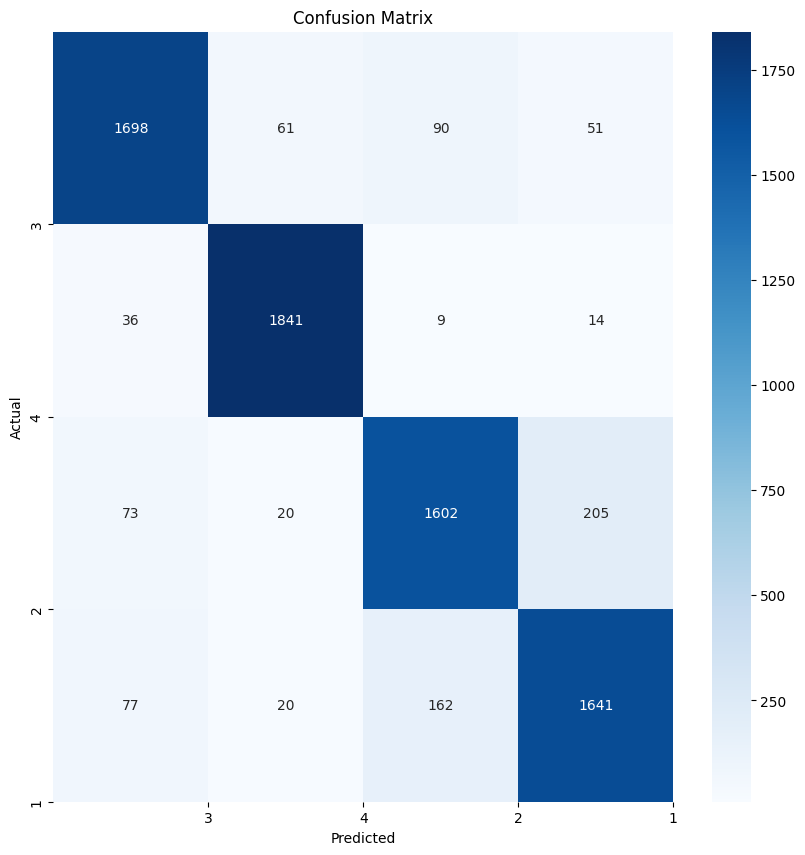

None


In [56]:
# code here
y_pred = test_model(X_test, y_test, prior_prob, log_likelihood, classes)

def evaluation(y_true, y_pred):
    print(classification_report(y_true, y_pred))

evaluation(y_test, y_pred)

### 2.4 - Discussion

Answer the following questions:
- How did you decide what kind of pre-processing to do? How did this effect the performance of the classifier?
- How does your f1 score rate the performance of your model? What can be done to improve it?
- The given dataset has an equal number of samples in each class. How, if at all, would the performance of the model change if the data had a class imbalance?
- The fundamental Naïve Bayes assumption is that each feature makes an independent and equal contribution to the outcome. Is this strictly true for this dataset? How might the assumption have impacted the predictions?

Answer here:

1. Initially only whitespaces and punctuations were removed, which led to a mediocre accuracy. However, once I removed digits, punctuations, and stop words the accuracy of the classifier improved a lot. Similarly, urls were removed as well after observing that they were not adding any value to the classification task.
2. 0.89 is a very good F1 score, where the model is able to classify the articles with a high precision and recall. That is, the model gives a high correct number of positive class predictions that actually belong to the positive class, for each class in this case of multiclassification, and the model also has a high ratio of the number of positive class predictions made out of all positive examples in the dataset. The model can be improved by using a more complex model, such as a deep learning model. Similarly, better and even more advanced pre-processing techniques can be used to improve the performance of the model.
3. If dataset had a class imbalance, the model would have a hard time classifying the minority class. This is because the model would have a hard time learning the features of the minority class. To overcome this, we can use a sampling technique such as SMOTE, or fair-SMOTE to oversample the minority class.
4. Each feature is generally not independent of each other. A few words are more likely to appear together than others. For example, the word "Trump" is more likely to appear with the word "president" than the word "apple". This assumption can impact the predictions by making the model less accurate. Thus the assumption of independence is not true and does not take into account the context of the words.